In [1]:
import functools
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")

from heat.approximator import HeatApproximator
from heat.plot import plot, plot_image
from heat.trajectory import IsDivergingPrecise, compare_trajectory
from neural_rk import fitting
from neural_rk.hyperparameter import HyperParameter
from neural_rk.modules import RungeKutta, prune_state_dict
from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR
from neural_rk.scheduler import get_scheduler
from neural_rk.trainer import rollout

mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath, amssymb}"

# Rollout

In [2]:
device = torch.device("cuda:0")
exp_id = "A"
test_id = "A_test"

result_dir = RESULT_DIR / f"heat_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"heat_{test_id}.pkl")
times = np.array(
    [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]


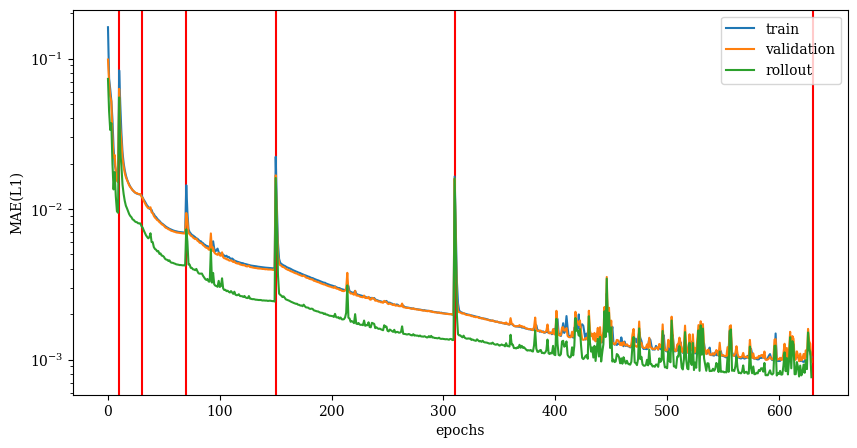

In [6]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    ax.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [3]:
approximator = HeatApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

heat_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [14]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(heat_rollout(series=test_df.iloc[idx]).cpu().numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

In [3]:
# with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
#     pickle.dump(pred_trajectories, f)

with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)

# Analyze

In [4]:
maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, rr, N=130 Maximum err: 1.8543e-03 at step=51, node=9, MAE 3.6420e-04
idx=1, rr, N=64 Maximum err: 2.4424e-03 at step=67, node=38, MAE 5.9660e-04
idx=2, rr, N=109 Maximum err: 4.0287e-03 at step=97, node=63, MAE 4.8361e-04
idx=3, er, N=80 Maximum err: 2.6644e-03 at step=15, node=30, MAE 4.1273e-04
idx=4, er, N=121 Maximum err: 2.3873e-03 at step=22, node=65, MAE 4.8345e-04
idx=5, ba, N=104 Maximum err: 1.6265e-03 at step=100, node=16, MAE 2.8641e-04
idx=6, ba, N=123 Maximum err: 2.5194e-03 at step=100, node=62, MAE 4.4530e-04
idx=7, er, N=69 Maximum err: 3.2277e-03 at step=13, node=4, MAE 6.5664e-04
idx=8, er, N=123 Maximum err: 3.2235e-03 at step=100, node=95, MAE 3.8513e-04
idx=9, er, N=83 Maximum err: 1.7854e-03 at step=25, node=38, MAE 3.6346e-04
idx=10, ba, N=56 Maximum err: 1.7772e-03 at step=4, node=3, MAE 3.6073e-04
idx=11, rr, N=87 Maximum err: 1.6591e-03 at step=31, node=1, MAE 3.6501e-04
idx=12, rr, N=112 Maximum err: 8.1336e-03 at step=100, node=64, MAE 5.1514e-04
idx

## Single sample

In [19]:
sample_idx = 37

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0.0, times[sample_idx][-1], 5), 2)
true_trajectory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
time = times[sample_idx]
error = true_trajectory - pred_trajectory

print(f"{error.min():.2e} < error < {error.max():.2e}")

rr
-8.19e-04 < error < 1.80e-03


plot node with index: [69 71 74 44 46 15 60 61 62 63]


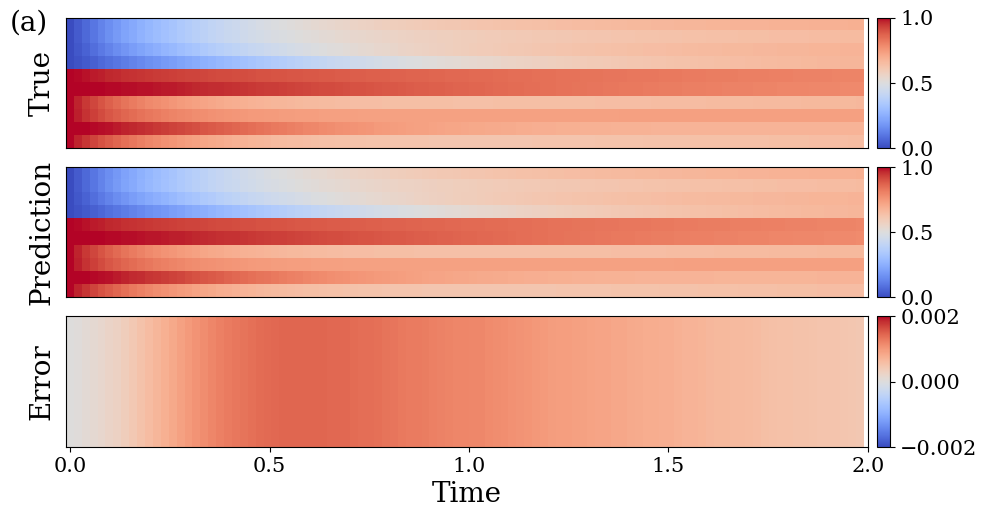

In [20]:
# nodes = np.random.choice(np.arange(true_trajectory.shape[1]), 10, replace=False)
nodes = set()
# for idx in np.argsort(np.abs(error).sum(axis=0).flatten()): # minimum
for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:  # maximum
    idx = np.unravel_index(idx, error.shape[1:])
    nodes.add(idx[0])
    if len(nodes) == 10:
        break
nodes = np.array(list(nodes), dtype=np.int64)
# nodes = true_trajectory.mean(axis=0)[:, 0].argsort()
print(f"plot node with index: {nodes}")
xticks = np.linspace(0.0, 2.0, 5)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)
ax1.set_ylabel("True", fontsize=20)
# plot(ax1, true_trajectory, time, nodes)
im1 = plot_image(ax1, true_trajectory, nodes, xticks=xticks)
cbar1 = fig.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)
ax1.set_xticks([])
ax1.tick_params(axis="both", labelsize=15)
cbar1.ax.tick_params(labelsize=15)

ax2.set_ylabel("Prediction", fontsize=20)
# plot(ax2, pred_trajectory, time, nodes)
im2 = plot_image(ax2, pred_trajectory, nodes, xticks=xticks)
cbar2 = fig.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)
ax2.set_xticks([])
ax2.tick_params(axis="both", labelsize=15)
cbar2.ax.tick_params(labelsize=15)

ax3.set_ylabel("Error", fontsize=20)
# plot(ax3, error, time, nodes, lim=(-0.002, 0.002))
im3 = plot_image(ax3, error, nodes, xticks=xticks, lim=(-0.002, 0.002))
cbar3 = fig.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)
ax3.tick_params(axis="both", labelsize=15)
ax3.set_ylim(-0.002, 0.002)
ax3.set_xlabel("Time", fontsize=20)
cbar3.ax.tick_params(labelsize=15)

ax1.text(-0.07, 0.9, "(a)", transform=ax1.transAxes, fontsize=20)


fig.tight_layout(pad=0.0)
# fig.savefig(
#     f"{FIG_DIR}/heat_{test_id}_{sample_idx}_{exp_id}.pdf",
#     bbox_inches="tight",
#     pad_inches=0.0,
# )
fig.show()

## Statisics over samples

slope: 0.0684 pm 0.0955
slope of averaged curve: 0.0783


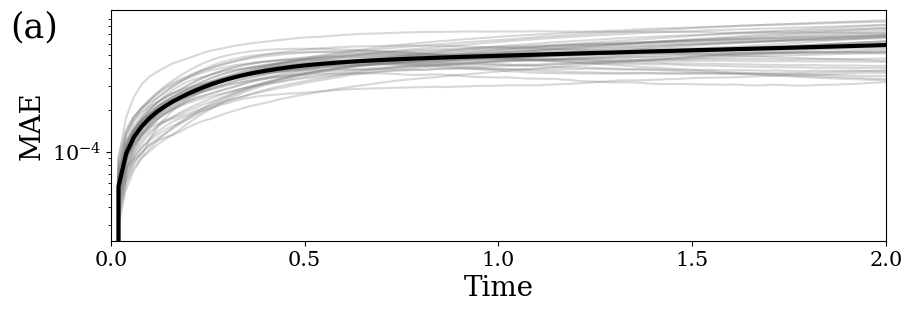

In [11]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 0.75, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    ax.plot(sample_time, sample_mae, color="gray", alpha=0.3)
    # ax.plot(sample_time, sample_mae, color=colors[network_type], alpha=0.3)

    mask = sample_time > fit_range
    if yscale == "log":
        _, _, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        _, _, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)


final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4f} pm {np.std(slopes):.4f}")
print(f"slope of averaged curve: {slope:.4f}")
# ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
# ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0.0)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("MAE", fontsize=20)
ax.tick_params(axis="both", labelsize=15)
ax.set_xlim(0.0, 2.0)
ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([1e-4])
ax.text(-0.13, 0.88, "(a)", transform=ax.transAxes, fontsize=25)

fig.savefig(
    f"{FIG_DIR}/heat_mae_{test_id}_{exp_id}.pdf", bbox_inches="tight", pad_inches=0.0
)
fig.show()